In [1]:
## Springboard Data Science Track Capstone Project 2
### Music Genre Classification from Audio Samples
### by Morgan Fry
### Data Exploration and Analysis notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import librosa

import pickle
import seaborn as sns

import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler

Using TensorFlow backend.


For the baseline model, we'll work with the small dataset, and the preprocessed track data.

In [2]:
features=pd.read_csv('data/features.csv',index_col=0, header=[0,1,2])
tracks=pickle.load(open("saved/tracks.p","rb"))

np.testing.assert_array_equal(features.index, tracks.index)

In [3]:
#using the 8000 track balanced subset for baseline modeling
subset = tracks.index[tracks['set', 'subset'] == 'small']
tracks = tracks.loc[subset]
features_all = features.loc[subset]

In [4]:
#use the train/test/validation split provided with the fma dataset 
#so we can compare accurately to past and future models

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']


In [26]:
columns=['mmfcc','chroma_stft','tonnetz']
features_all.loc[val,columns].shape

(800, 126)

In [124]:
#preprocessing multilabel

enc=MultiLabelBinarizer()
labels=tracks['track', 'genres_all']


# Split in training, validation and testing sets.
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
X_train = features_all.loc[train].values
X_val = features_all.loc[val].values
X_test = features_all.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [125]:
len(y_val)

800

In [126]:
    
# Standardize features by removing the mean and scaling to unit variance.
scaler =StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_val)
scaler.transform(X_test)

array([[ 0.1253238 ,  0.59807614, -0.10177305, ..., -0.10643952,
        -0.8105098 , -0.84468934],
       [-0.34768999, -0.35213792, -0.0645586 , ..., -0.51699423,
        -0.23005883,  1.11347606],
       [-0.0231874 , -0.03538058, -0.03524516, ..., -0.51699423,
         0.08205794,  0.54353052],
       ...,
       [-0.47744417, -0.39346363, -0.15097715, ..., -0.31171687,
         0.04967999,  2.57694115],
       [-0.52918994, -0.47181669, -0.1345473 , ..., -0.10643952,
         1.22919953,  1.71213092],
       [-0.46718922, -0.3620704 , -0.06173892, ...,  1.33050197,
        -0.01398353,  3.47595249]])

In [127]:
y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [130]:
#fully connected neural net for baseline

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(256, activation='relu',input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))


#optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
optimizer=keras.optimizers.adam()
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               132864    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 114)               7410      
Total params: 181,426
Trainable params: 181,426
Non-trainable params: 0
_________________________________________________________________


In [135]:
EPOCHS = 30
BS = 32
history=model.fit(X_train,y_train, epochs=EPOCHS, batch_size=BS)

Epoch 1/30
6400/6400 [==============================] - 0s 63us/step - loss: 1396071201.4400 - accuracy: 0.0659
Epoch 2/30
6400/6400 [==============================] - 0s 61us/step - loss: 1440625495.0400 - accuracy: 0.0677
Epoch 3/30
6400/6400 [==============================] - 0s 62us/step - loss: 1528845949.2800 - accuracy: 0.0636
Epoch 4/30
6400/6400 [==============================] - 0s 62us/step - loss: 1609916877.1200 - accuracy: 0.0709
Epoch 5/30
6400/6400 [==============================] - 0s 62us/step - loss: 1704953051.5200 - accuracy: 0.0594
Epoch 6/30
6400/6400 [==============================] - 0s 62us/step - loss: 1909955909.7600 - accuracy: 0.0613
Epoch 7/30
6400/6400 [==============================] - 0s 61us/step - loss: 2007802589.1200 - accuracy: 0.0656
Epoch 8/30
6400/6400 [==============================] - 0s 62us/step - loss: 2152597521.6000 - accuracy: 0.0708
Epoch 9/30
6400/6400 [==============================] - 0s 63us/step - loss: 2332889837.7600 - accuracy:

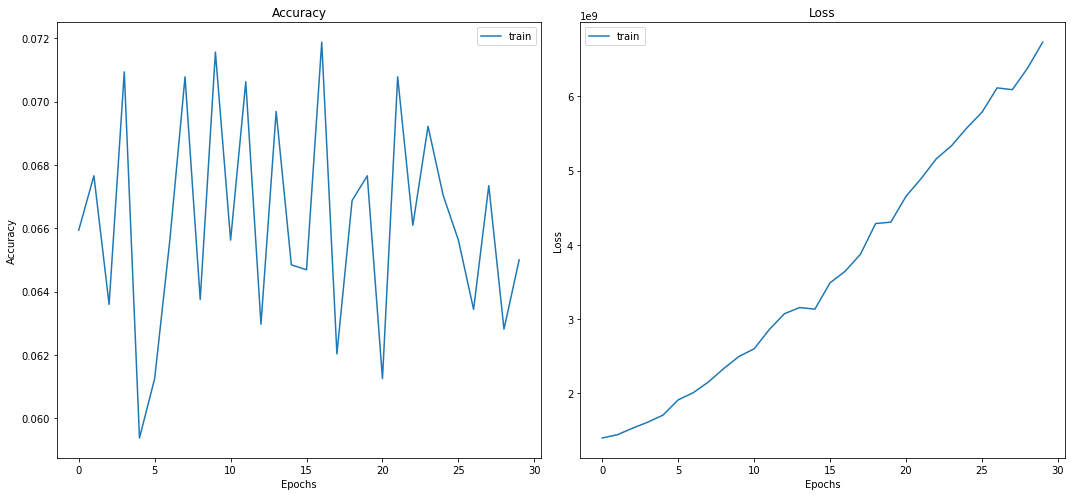

In [140]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.fit_generator(SampleLoader(X_train, batch_size=16), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=16), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=16), test.size, **params)
#Y = model.predict_generator(loader, test.size, pickle_safe=True, nb_worker=NB_WORKER, max_q_size=5)

loss

In [ ]:
#baseline model from fma

loader = utils.FfmpegLoader(sampling_rate=16000)
#loader = utils.LibrosaLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((-1, 1), input_shape=loader.shape))
print(model.output_shape)

model.add(Conv1D(128, 512, subsample_length=512))
print(model.output_shape)
model.add(Activation("relu"))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

print(model.output_shape)
#model.add(Dropout(0.25))
model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
model.add(Activation("relu"))
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=10), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=10), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=10), test.size, **params)

loss